# Creating custom focal statistic function

In [1]:
import pyspatialstats.focal_stats as fs
import pyspatialstats.rolling as rolling
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
os.chdir("../../../")

Loading raster (containing water table depth (Fan et al., 2017)).

In [3]:
with rio.open("data/wtd.tif") as f:
    a = f.read(1).astype(np.float64)
    a[a == -999.9] = np.nan

Inspecting the data

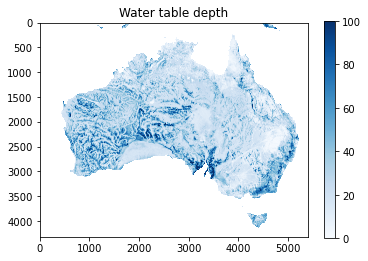

In [4]:
plt.imshow(a, cmap='Blues', vmax=100)
plt.title("Water table depth")
plt.colorbar()

## Creating custom focal mean

Firstly, a windowed version of the input raster needs to be defined.

In [9]:
a_windowed = rolling.rolling_window(a, window=5)
print(a.shape, a_windowed.shape)

(4320, 5400) (4316, 5396, 5, 5)


This windowed version has a slightly different shape on the first two axes. This is because there is no window behaviour defined on the edges. If this is undesired the original array can be padded with the missing number of columns and rows with numpy.pad. Through this function many different edge value assumptions can be made. Here I use the example of continuing with the closest values.

In [10]:
a_padded = np.pad(a, pad_width=2, mode='edge')
a_windowed_padded = rolling.rolling_window(a_padded, window=5)
print(a.shape, a_windowed_padded.shape)

(4320, 5400) (4320, 5400, 5, 5)


This has the result that the input and output raster share their first two axes.

Now the only thing that needs to happen is a mean operation on the third and fourth axes:

In [12]:
a_mean = a_windowed.mean(axis=(2, 3))

Plotting this shows that the operation generates an image that is very close to the original raster, with some limited smoothing

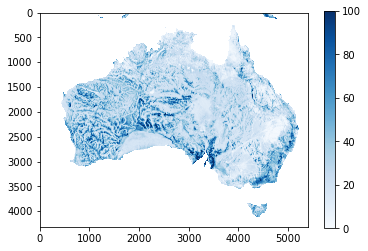

In [14]:
plt.imshow(a_mean, cmap="Blues", vmax=100)
plt.colorbar()

This can be captured in a custom focal_mean function as follows:

In [16]:
def focal_mean(a, window):
    a_windowed = rolling.rolling_window(a, window=window)
    return a_windowed.mean(axis=(2, 3))

Resulting in the same image:

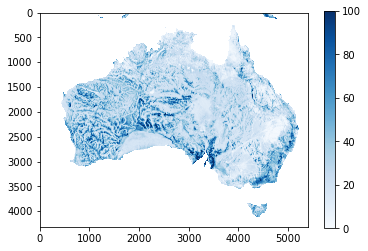

In [17]:
plt.imshow(fs.focal_mean(a, window=5), cmap="Blues", vmax=100)
plt.colorbar()

Note that if a single NaN-value was present in the window, it results in a NaN-value. I dealt with this by inserting 0 in the pixels with NaN-values and using the sum of this array divided by the number of valid values per window (e.g. ``rolling_sum(~np.isnan(a), window=5)``).